<a href="https://colab.research.google.com/github/gerritgr/Alia/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AliaMolecule Inference

#### Project Name

In [1]:
#!pip install wandb --force-reinstall

In [2]:
PROJECT_NAME = "AliaMoleculeDeskII"
PATH_PATTERN_BASE = "aliamol_paper" #aliamol2 is trained on denoised image
BASELINE = False


DEBUG = False
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


#### Setup

In [3]:
# Load drive

import os
USE_COLAB = False
try:
  from google.colab import drive
  USE_COLAB = True
except:
  pass

try:
  import wandb # need to do this before chaning cwd
except:
  os.system("pip install wandb")


if USE_COLAB:
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  dir_path = f'/content/drive/MyDrive/colab/{PROJECT_NAME}/'
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  print("Current Working Directory: ", os.getcwd())
  if os.getcwd() != dir_path:
    os.chdir(dir_path)
    print("New Working Directory: ", os.getcwd())

Mounted at /content/drive
Current Working Directory:  /content
New Working Directory:  /content/drive/MyDrive/colab/AliaMoleculeColabI


In [4]:
# Install packages

import os
import torch
torch_version = torch.__version__.split("+")
#os.environ["TORCH"] = torch_version[0]
#os.environ["CUDA"] = torch_version[1]
try:
  import torch_geometric
except:
  os.system("pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html")
  os.system("pip install torch-geometric")

try:
  import rdkit
except:
  os.system("pip install rdkit")

PATH_PATTERN = PATH_PATTERN_BASE

#### Imports

In [5]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
#import imageio # to generate .gifs
import networkx as nx

# always good to have
import glob, random, os, traceback, time, copy
import pickle
import numpy as np
import networkx as nx
import math
from tqdm import tqdm
import gzip

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import Linear as Lin
from torch.nn import Sequential as Seq
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GraphNorm, BatchNorm
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.nn import global_mean_pool, global_add_pool

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')

### Load External

In [6]:
if not os.path.exists("smiles_to_pyg"):
  os.system("git clone https://github.com/gerritgr/Alia.git && cp -R Alia/* .")
from smiles_to_pyg.molecule_load_and_convert import *

#### Hyperparams

In [7]:
##
## Diffusion
##
TIMESTEPS = 1000
START = 0.0001
END = 0.015

# Training
BATCH_SIZE = 128*2
GAMMA = 0.1

##
## Pred
##
LEARNING_RATE_GEN = 0.001
EPOCHS_GEN = 100

### PNA Pred
DROPOUT_PRED = 0.05
DEPTH_PRED = 4
HIDDEN_CHANNELS_PRED = 32
TOWERS_PRED = 1
NORMALIZATION_PRED = True

##
## Disc
##
EPOCHS_DISC_MODEL = 70
DISC_NOISE=0.3

### PNA Disc
HIDDEN_CHANNELS_DISC = 8
DEPTH_DISC = 4
DROPOUT_DISC = 0.05
NORMALIZATION_DISC = True


##
## Molecule Encoding
##

INDICATOR_FEATURE_DIM = 1
FEATURE_DIM = 5 # (has to be the same for atom and bond)
ATOM_FEATURE_DIM = FEATURE_DIM
BOND_FEATURE_DIM = FEATURE_DIM
NON_NODES = [True] + [False]*5 + [True] * 5
NON_EDGES = [True] + [True]*5 + [False] * 5

TIME_FEATURE_DIM = 1

# Utils

In [8]:
def log(d):
  try:
    import wandb
    wandb.log(d)
  except:
    print(d)

In [9]:
def load_file(filepath):
  print("try to read ", filepath)
  try:
    with gzip.open(filepath, 'rb') as f:
      return pickle.load(f)
  except Exception as e:
      print(f"An error occurred: {str(e)}")
      raise

def write_file(filepath, data):
  try:
    data = data.cpu()
  except:
    pass
  print("try to write ", filepath)
  with gzip.open(filepath, 'wb') as f:
    pickle.dump(data, f)

In [10]:

def build_dataset(seed=1234):
  try:
    dataset_train, dataset_test = load_file('dataset.pickle')
    if DEBUG:
      return dataset_train[:len(dataset_train)//10], dataset_test[:len(dataset_test)//10]
    return dataset_train, dataset_test
  except Exception as e:
    print(f"Could not load dataset due to error: {str(e)}, generate it now")

  dataset = read_qm9()
  dataset_all = [g for g in dataset if g.x.shape[0] > 1]
  dataset = list()
  for g in tqdm(dataset_all):
    try:
      assert "None" not in str(pyg_to_smiles(g))
      dataset.append(g)
    except:
      pass
  print("Built and clean dataset, length is ", len(dataset), "old length was", len(dataset_all))
  random.Random(seed).shuffle(dataset)
  split = int(len(dataset)*0.8 + 0.5)
  dataset_train = dataset[:split]
  dataset_test = dataset[split:]
  assert(dataset_train[0].x[0,:].numel() == INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM)

  write_file("dataset.pickle", (dataset_train, dataset_test))
  return dataset_train, dataset_test


In [11]:
def generate_schedule(start = START, end = END, timesteps=TIMESTEPS):
  """
  Generates a schedule of beta and alpha values for a forward process.

  Args:
  start (float): The starting value for the beta values. Default is START.
  end (float): The ending value for the beta values. Default is END.
  timesteps (int): The number of timesteps to generate. Default is TIMESTEPS.

  Returns:
  tuple: A tuple of three tensors containing the beta values, alpha values, and
  cumulative alpha values (alpha bars).
  """
  betas = torch.linspace(start, end, timesteps, device = DEVICE)
  #alphas = 1.0 - betas
  #alpha_bars = torch.cumprod(alphas, axis=0)
  assert(betas.numel() == TIMESTEPS)
  return betas

In [12]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

def visualize_smiles_from_file(filepath):
    print("visualize molecules")
    # Read SMILES from file
    with open(filepath, 'r') as file:
        smiles_list = [line.split("'")[1] for line in file.readlines() if "'" in line]

    # Convert SMILES to RDKit Mol objects, filtering out invalid ones
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list[:100]]
    mols = [mol for mol in mols if mol is not None]
    print("mols to plot:", mols)

    # Determine grid size
    num_mols = len(mols)
    cols = 10
    rows = min(10, -(-num_mols // cols))  # ceil division

    # Create a subplot grid
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20),
                            gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

    for i in range(rows):
        for j in range(cols):
            ax = axs[i, j]
            ax.axis("off")  # hide axis
            idx = i * cols + j  # index in mols list
            if idx < num_mols:
                img = Draw.MolToImage(mols[idx], size=(200, 200))
                ax.imshow(img)
            else:
                break

    # Save the figure
    plt.savefig(filepath + '.jpg', format='jpg', bbox_inches='tight')
    plt.close(fig)  # Close the figure after saving to free up memory
    #try:
    time.sleep(0.01)
    wandb.log_artifact(filepath + '.jpg', name=f"jpg_{SWEEP_ID}_{filepath.replace('.','')}", type="smiles_grid_graph")
    #except Exception as e:
    #    print(e)
    #    pass

# Example usage:
# Replace YOUR_FILE_PATH with the path to your SMILES file.
# visualize_smiles_from_file(YOUR_FILE_PATH)


# Base Model

In [13]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree


def dataset_to_degree_bin(train_dataset):
  try:
    deg = load_file('deg.pickle')
    deg = deg.to(DEVICE)
    return deg
  except Exception as e:
    print(f"Could not find degree bin due to error: {str(e)}, generate it now")
  assert(train_dataset is not None)


  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

  write_file("deg.pickle", deg.cpu())
  return deg





class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=HIDDEN_CHANNELS_PRED, depth=DEPTH_PRED, dropout=DROPOUT_PRED, towers=TOWERS_PRED, normalization=NORMALIZATION_PRED, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1) #tod fix
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM+ TIME_FEATURE_DIM #INDICATOR_FEATURE_DIM entries are noise free
    out_channels = FEATURE_DIM

    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, out_channels))


  def forward(self, x_in, t, edge_index):
    row_num = x_in.shape[0]
    t = t.view(-1,TIME_FEATURE_DIM)
    x = torch.concat((x_in, t), dim=1)
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    assert(x.numel() > 1 )
    assert(x.shape[0] == row_num)

    #node_indicator = x_in[:,0] > 0
    #node_indicator = x_in[:,0] < 0
    #x[node_indicator, NON_NODES] = x_in[node_indicator, NON_NODES]
    #x[edge_indicator, NON_EDGES] = x_in[edge_indicator, NON_EDGES]

    return x


#model = PNAnet([data])

#model(data.x, data.edge_index, torch.ones(data.x.shape[0]))

In [14]:
#path_pattern = "aliamol_model_epoch_*.pth"
#sorted(glob.glob(path_pattern))

In [15]:
def load_latest_checkpoint(model, optimizer, loss_list, epoch_i, path_pattern=None):
  if path_pattern is None:
    path_pattern = PATH_PATTERN + "_model_epoch_*.pth"
  try:
    checkpoint_paths = sorted(glob.glob(path_pattern))
    if len(checkpoint_paths) == 0:
      return model, optimizer, loss_list, epoch_i

    latest_checkpoint_path = checkpoint_paths[-1]
    checkpoint = torch.load(latest_checkpoint_path, map_location=DEVICE)

    # Assuming model and optim are your initialized model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_i = checkpoint['epoch']
    loss_list = checkpoint['loss_list']
    print(f"read checkpoint of epoch {epoch_i:08} from disc.")
  except:
    pass

  return model, optimizer, loss_list, epoch_i

def save_model(model, optimizer, loss_list, epoch_i, upload=False):
  if epoch_i == 0:
    return
  save_path = f"{PATH_PATTERN}_model_epoch_{epoch_i:08}.pth"

  # Save the model state dict and the optimizer state dict in a dictionary
  torch.save({
              'epoch': epoch_i,
              'loss_list': loss_list,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, save_path)
  if upload:
    try:
      wandb.log_artifact(save_path, name=f"src_txt_{SWEEP_ID}_{epoch_i:08}_weightfile", type="weight")
    except Exception as e:
      print(e)
      pass


In [16]:
def load_base_model(dataset_train, path_pattern=None):
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)
  loss_list = None
  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE_GEN)
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0, path_pattern=path_pattern)

  return model_base

# Inference

In [17]:
def denoise_one_step_wild(model, g, i):
  betas = generate_schedule()
  t = TIMESTEPS - i - 1 # i=0 is full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  row_num = g.x.shape[0]

  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1,1)

  denoised_x = g.x.clone()
  original_pred = model(g.x, future_t, g.edge_index)

  #noise_pred = noise_pred.view(row_num, -1)
  #x_with_noise = g.x[mask].view(row_num, -1)
  #assert(noise_pred.shape == x_with_noise.shape)
  #future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  #original_pred = get_pred_from_noise(noise_pred, x_with_noise, future_t)

  if t-1>0:
    x_with_noise_again, _ = forward_diffusion(original_pred, t-1)
    denoised_x[mask] = x_with_noise_again.flatten()
  else:
    denoised_x[mask] = original_pred.flatten()
  return denoised_x



  #x_in = g.x[mask].flatten()
  #original_pred = get_pred_from_noise(noise_pred, x_in, future_t)
  ##original_pred = (x_in - torch.sqrt(1. - alphas_cumprod_t) * noise_pred)/torch.sqrt(alphas_cumprod_t)
  #assert(original_pred.shape[0] = x_in.shape[0])
  #x = g.x.clone()
  #x[mask] = original_pred
  #if t-1 <= 0:
  #  return x
  #x_with_noise_again, _ = forward_diffusion(x, t-1)
  #denoised_x[mask] = x_with_noise_again[mask]
  #return denoised_x


In [18]:
def denoise_one_step(model, g, i):
  row_num = g.x.shape[0]

  betas = generate_schedule()
  t = TIMESTEPS - i - 1 # i=0 is full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)


  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)

  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1,1)

  original_pred = model(g.x, future_t, g.edge_index)

  x_with_noise = g.x[mask].view(row_num, -1)
  future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  noise_pred = get_noise_from_pred(original_pred, x_with_noise, future_t)

  values_now = g.x[mask].view(row_num, -1)
  values_endpoint = noise_pred.view(row_num, -1)#[mask] network only prdicts noise

  assert(values_now.shape == values_endpoint.shape)

  # now compute values_one_step_denoised
  model_mean = sqrt_recip_alphas_t * (values_now - beta_t * values_endpoint / sqrt_one_minus_alphas_cumprod_t)
  values_one_step_denoised = model_mean # if t == 0
  if t != 0:
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # in the paper this is in 3.2. note that sigma^2 is variance, not std
    posterior_std_t = torch.sqrt(posterior_variance[t])
    noise = torch.randn_like(values_now, device = DEVICE)
    values_one_step_denoised = model_mean + posterior_std_t * noise

  denoised_x = g.x.clone()
  denoised_x[mask] = values_one_step_denoised.flatten()
  return denoised_x


In [19]:
def overwrite_with_noise(g):
  g.x_old = g.x.clone()
  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  g.x[mask] = torch.randn_like(g.x[mask])
  return g


In [20]:
@torch.inference_mode()
def generate_examples(model, dataset_train, num=100,wild=False):
  # Setup
  print("generate samples batched")
  model.eval()
  dataset_train_start = list()
  while len(dataset_train_start) < num:
    g = dataset_train[random.sample(range(len(dataset_train)),1)[0]]
    dataset_train_start.append(g.clone().to(DEVICE))
    g = dataset_train_start[-1]
  assert(len(dataset_train_start) == num)
  dataloader = DataLoader(dataset_train_start, batch_size = num)

  # Inference
  for g in dataloader:
    g = g.to(DEVICE)
    print("load g", g, g.batch)
    g = overwrite_with_noise(g)
    for i in tqdm(range(TIMESTEPS)):
      t = int(TIMESTEPS-i-1)
      if wild:
        x_with_less_noise = denoise_one_step_wild(model, g, i)
      else:
        x_with_less_noise = denoise_one_step(model, g, i)
      g.x = x_with_less_noise

    graph_list = g.to_data_list()
    graph_list = [g.cpu() for g in graph_list]

    print("generated graphs ", graph_list[:10])
    return graph_list


#### Frac Correct

In [21]:
def find_frac_correct(graphs):
  correct = 0
  smiles_list = list()
  for i, g in tqdm(list(enumerate(graphs))):
    smiles = pyg_to_smiles(g)
    if smiles is not None and '.' not in smiles:
      mol = Chem.MolFromSmiles(smiles)
      if mol is not None:
        correct += 1
        smiles_list.append((smiles, i))

  frac_correct = correct/len(graphs)
  smiles_list_0 = [s[0] for s in smiles_list_0]
  unique_frac = len(list(set(smiles_list_0)))/len(graphs)
  return frac_correct, smiles_list, unique_frac

### Gen many graphs

In [22]:
#!ls aliamol2*

In [23]:
def gen_graphs(num_per_generation=1000, num_generations=40, wild=False, path_pattern=None):
  if DEBUG:
    num_generations = int(num_generations/10)
  if path_pattern is None:
    path_pattern = PATH_PATTERN+"_model_epoch_*.pth" #"aliamol_model_epoch_*.pth"
  path = sorted(glob.glob(path_pattern))[-1]
  num_samples = num_per_generation*num_generations
  filepath = path.replace(".pth", f'_{num_samples:06d}_w{wild}_generated.pickle')

  results = list()
  try:
    results = load_file(filepath)
  except:
    pass

  if len(results) == num_per_generation*num_generations:
    return results

  dataset_base, dataset_base_test = build_dataset()
  scatter_list = list()
  model_base = load_base_model(dataset_base, path_pattern = path)

  i = 0
  while len(results) < num_samples:
    i += 1
    num = max(num_per_generation, len(results) - num_samples)
    graphs = generate_examples(model_base, dataset_base, num=num, wild=wild)
    results = results + graphs
    if i % 5 == 0 or len(results) >= num_samples:
      write_file(filepath, results)

  assert(len(results) == num_per_generation*num_generations)
  return results



def test_graph_generation(path_pattern=None, wild=False):
  generated_graphs = gen_graphs(wild=wild, path_pattern=path_pattern)
  return find_frac_correct(generated_graphs) #0.54 #0.02

In [24]:
#test_graph_generation(path_pattern="aliamol_model_epoch_00003901.pth")

# Discriminator

In [25]:
from torch_geometric.nn import PNA


class PNAdisc(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=HIDDEN_CHANNELS_DISC, depth=DEPTH_DISC, dropout=DROPOUT_DISC, towers=1, normalization=NORMALIZATION_DISC, pre_post_layers=1):
    super(PNAdisc, self).__init__()
    self.sigmoid = nn.Sigmoid()

    hidden_channels = towers * ((hidden_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM
    assert in_channels == 11
    deg = dataset_to_degree_bin(train_dataset)
    deg = deg.to(DEVICE)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)
    #self.pnanet = PNA(in_channels=11, hidden_channels=hidden_channels, out_channels=1, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg)

    #self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(),Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index, batch=None):
    #print("before: x.shape",x.shape, "edge_index.shape",edge_index.shape)
    x = x + torch.randn_like(x)*DISC_NOISE
    x = self.pnanet(x, edge_index)
    #print("after: x.shape",x.shape, "edge_index.shape",edge_index.shape)
    x = global_mean_pool(x, batch)
    #x = torch.sum(x)
    x = self.sigmoid(x)

    return x

In [26]:
def train_epoch_disc(model_disc, dataloader, optimizer):
  model_disc.train()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    optimizer.zero_grad()
    #print("batch.x, batch.edge_index, batch.batch", batch, batch.x, batch.edge_index, batch.batch)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    #print("pred ",pred, "y ", batch.y)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    loss.backward()
    optimizer.step()

    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [27]:
def test_disc(model_disc, dataloader):
  model_disc.eval()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [28]:
def train_disc_model(dataloader_disc, dataloader_disc_test, round_i):
  model_disc = PNAdisc(dataloader_disc)
  model_disc = model_disc.to(DEVICE)
  weight_path = f"discriminator_model_{round_i:05}.pth"

  try:
    checkpoint = torch.load(weight_path)
    model_disc.load_state_dict(checkpoint['model_state_dict'])
    print(f"found disc model in round {round_i:05}")
    return model_disc
  except:
    pass

  epochs = list()
  losses_train = list()
  losses_test = list()

  optimizer_disc = Adam(model_disc.parameters(), lr = 0.0001)
  for epoch_i in range(EPOCHS_DISC_MODEL):
    loss_train, acc_train, t_train = train_epoch_disc(model_disc, dataloader_disc, optimizer_disc)
    if epoch_i % 10 == 1 or epoch_i == EPOCHS_DISC_MODEL-1:
      loss_test, acc_test, t_test = test_disc(model_disc, dataloader_disc_test)
      #print(loss_train,loss_test,acc_train,acc_test,t_train)
      print(f"train discriminator: epoch: {epoch_i:05}, loss: {loss_train:02.4f}, loss test: {loss_test:02.4f}, acc: {acc_train:01.3f}, acc test: {acc_test:01.3f}, time: {t_train:01.3f}")
      log({"disc/step": epoch_i, "disc/epoch": epoch_i, "disc/loss_train": loss_train, 'disc/loss_test': loss_test, "disc/acc_trian": acc_train, "disc/acc_trian": acc_test, "disc/time": t_train})
      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)
      plt.clf()
      plt.plot(epochs, losses_train, label='train')
      plt.plot(epochs, losses_test, label='test')
      plt.legend()
      plt.savefig(f"discriminator_model_{round_i:05}.png")

  torch.save({'model_state_dict': model_disc.state_dict(), 'epochs': epochs, "losses_train": losses_train, "losses_test": losses_test}, weight_path)
  return model_disc


In [29]:
def run_disc(round_i=1):
  fake_graphs = gen_graphs(wild=False)
  dataset_base, dataset_base_test = build_dataset()
  real_graphs = random.sample(dataset_base, len(fake_graphs))
  dataset = list()

  for g in fake_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(0.0)
    dataset.append(g_i)

  for g in real_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(1.0)
    dataset.append(g_i)

  random.shuffle(dataset)
  cut_off = int(len(dataset) * 0.8)
  dataloader_train = DataLoader(dataset[:cut_off], batch_size = BATCH_SIZE, shuffle=True)
  dataloader_test = DataLoader(dataset[cut_off:], batch_size = BATCH_SIZE, shuffle=True)

  model_disc = train_disc_model(dataloader_train, dataloader_test, round_i)
  return model_disc


In [30]:
#model_disc = run_disc() #0000390 is the last good one

# Forward Diffusion

In [31]:
def forward_diffusion(node_features, future_t):
  """
  Performs a forward diffusion process on an node_features tensor.
  Each row can theoreetically have its own future time point.
  Implements the second equation from https://youtu.be/a4Yfz2FxXiY?t=649
  """
  row_num = node_features.shape[0]

  if "class 'int'" in str(type(future_t)) or "class 'float'" in str(type(future_t)):
    future_t = torch.tensor([int(future_t)] * row_num).to(DEVICE)

  feature_dim = node_features.shape[1]
  future_t = future_t.view(-1)
  assert(row_num == future_t.numel())
  assert(future_t[0] == future_t[1]) #lets assume the belong to the same graph

  betas = generate_schedule()

  noise = torch.randn_like(node_features, device=DEVICE)
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)
  assert(alphabar_t.numel() == row_num)

  new_node_features_mean = torch.sqrt(alphabar_t) * node_features # column-wise multiplication, now matrix #todo but we want row wise #.view(row_num,1)
  assert(new_node_features_mean.shape == node_features.shape)
  new_node_features_std = torch.sqrt(1.-alphabar_t) #this is a col vector
  new_node_features_std = new_node_features_std.repeat(1,feature_dim) #this is a matrix
  assert(new_node_features_mean.shape == new_node_features_std.shape)
  noisey_node_features =  new_node_features_mean + new_node_features_std * noise

  return noisey_node_features, noise

forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([0,0,999], device=DEVICE)), print(""), forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([999,999,999], device=DEVICE))

((tensor([[0.9896],
          [1.9771],
          [0.6485]], device='cuda:0'),
  tensor([[-1.0300],
          [-2.2795],
          [ 0.5812]], device='cuda:0')),
 None,
 (tensor([[-0.2222],
          [ 1.8517],
          [ 0.3940]], device='cuda:0'),
  tensor([[-0.2448],
          [ 1.8071],
          [ 0.3266]], device='cuda:0')))

# Train Jointly

In [32]:
def get_pred_from_noise(noise_pred, x_with_noise, future_t):

  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(1.0-alphabar_t)
  x_without_noise = x_with_noise - scaled_noise*noise_pred
  x_without_noise = x_without_noise/torch.sqrt(alphabar_t)
  return x_without_noise


def get_noise_from_pred(original_pred, x_with_noise, future_t):

  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(alphabar_t)
  noise = x_with_noise - scaled_noise*original_pred
  noise = noise / torch.sqrt(1.0-alphabar_t)

  return noise

In [33]:
def train_epoch(model, dataloader, optimizer, model_disc=None):
  schedule = generate_schedule()
  model.train()
  start_time = time.time()
  loss_list = list()
  loss_list_start = list()
  loss_row = nn.MSELoss(reduction='none')

  for batch in tqdm(dataloader): #todo batches deactivated
    if batch.x.shape[0] < 2:
      continue
    optimizer.zero_grad()
    batch.to(DEVICE)
    row_num = batch.x.shape[0]

    num_graphs_in_batch = int(torch.max(batch.batch).item()+1)
    future_t_select = torch.randint(0, TIMESTEPS, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.gather(future_t_select, 0, batch.batch)
    assert(future_t.numel() == row_num)

    mask = torch.concat((torch.tensor([False]*row_num, device=DEVICE).view(-1,1), batch.x[:,1:]>-0.5), dim=1) #this only works on original values
    x_start_gt = batch.x[mask].view(row_num, FEATURE_DIM)
    x_with_noise, noise_gt = forward_diffusion(x_start_gt, future_t)

    x_in = batch.x.clone()
    x_in[mask] = x_with_noise.flatten()
    x_start_pred = model(x_in, future_t, batch.edge_index)
    loss = F.mse_loss(x_start_gt, x_start_pred)


    #row_num = x_in.shape[0]
    #assert(x_with_noise.shape[0] == row_num)
   # assert(noise_pred.shape[0] == row_num)
    #assert(noise_pred.shape == x_with_noise.shape)
    #assert(noise_pred.shape == noise_gt.shape)
    #assert(noise_pred.shape == x_start_gt.shape)
    #x_start_pred = get_pred_from_noise(noise_pred, x_with_noise, future_t)

    #assert(F.mse_loss(get_pred_from_noise(noise_gt, x_with_noise, future_t), x_start_gt) < 0.00001)

    #loss = F.mse_loss(noise_gt, noise_pred)
    #loss_start = F.mse_loss(x_start_gt, x_start_pred)  #multiply with torch.sqrt(1.0-alphabar_t)  #F.mse_loss(x_start_gt, x_start_pred)  # torch.sum(F.mse_loss(x_start_gt, x_start_pred, dim=1)/future_t) #torch.sum(torch.sum((x_start_gt- x_start_pred)**2,dim=1) / (1+future_t.view(-1,1)))
    #loss_agg = loss + 0.5*loss_start

    #x_in = batch.x.clone()
    #x_in[mask] = x_start_pred.flatten()
    #disc_loss = torch.abs(1.0- model_disc(x_in, batch.edge_index, batch=batch.batch))
    #disc_loss = torch.mean(disc_loss)
    #loss_agg = loss + 0.25*disc_loss

    disc_loss = torch.tensor(0.0, device=DEVICE)
    if model_disc is not None:
      x_in[mask] = x_start_pred.flatten()
      disc_loss = torch.mean((1.0- model_disc(x_in, batch.edge_index, batch=batch.batch))**2)
      loss = (1.0 - GAMMA) * loss + GAMMA*disc_loss



    loss.backward()
    loss_list.append(loss.item())
    loss_list_start.append(disc_loss.item())
    optimizer.step()


  return np.mean(loss_list),np.mean(loss_list_start), time.time()-start_time

In [34]:
def log_smiles(smiles, filename):
  try:
    with open(filename, "w") as file:
      for string in smiles:
        file.write(str(string) + "\n")
    wandb.log_artifact(filename, name=f"src_txt_{SWEEP_ID}_{filename}", type="smiles")
    time.sleep(0.01)
    visualize_smiles_from_file(filename)
  except Exception as e:
    print(e)
    pass

In [35]:
def train_base_model(train_loader, epoch_num=EPOCHS_GEN, model_disc=None):
  print("train base model")
  if DEBUG:
    epoch_num = int(epoch_num/10)

  dataset_train = train_loader.dataset
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)

  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE_GEN*0.01) #ok makes no sense
  loss_list = list()
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0)

  epoch_start = min(epoch_start, epoch_num)
  print("from", epoch_start, "to", epoch_num)


  for epoch_i in range(epoch_start,epoch_num):
    try:
      loss, loss_start, time_elapsed = train_epoch(model_base, train_loader, optimizer, model_disc=model_disc)
      loss_list.append((epoch_i, loss))
      if epoch_i % 1 == 0 or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        #plot_list(loss_list, "train_base.png", title="train loss base model", xlabel='epoch', ylabel='loss')
        mean_loss = np.mean([y for x,y in loss_list] + [loss])
        print(f"loss in epoch {epoch_i:07} is: {loss:05.4f} with mean loss {mean_loss:05.4f} with start loss {loss_start:05.4f} with runtime {time_elapsed:05.4f}")
        log({"gen/step": epoch_i, "gen/epoch": epoch_i, "gen/loss": loss, "gen/mean_loss": mean_loss, "gen/start_loss": loss_start, "gen/runtime": time_elapsed})

      if (epoch_i % 20 == 0 and epoch_i > epoch_start) or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        #graphs = generate_examples(model_base, epoch_i, betas, dataset_train)
        #graph_loss_list.append(compute_generation_loss(graphs, None))
        #print(f"generation loss: {graph_loss_list[-1]:06.4f}")
        #plot_base(graph_loss_list, loss_list)
        #pass
        print("save")
        save_model(model_base, optimizer, loss_list, epoch_i+1, upload=epoch_i % 100 == 0 and epoch_i>9) #todo really +1?
        time.sleep(0.1)
        frac, smiles_list, unique_frac = test_graph_generation(wild=False)
        frac_wild, smiles_list_wild, unique_frac_wild = test_graph_generation(wild=True)
        print("frac correct graphs: ", frac, "with wild inference", frac_wild)
        log({"inference/step": epoch_i, "inference/epoch": epoch_i, "inference/frac_normal": frac, "inference/frac_wild": frac_wild, "inference/frac_normal_unique": unique_frac, "inference/frac_wild_unique": unique_frac_wild})
        log_smiles(smiles_list, f"{PATH_PATTERN}_smiles_{epoch_i}_normal.txt")
        log_smiles(smiles_list_wild, f"{PATH_PATTERN}_smiles_{epoch_i}_wild.txt")
        try:
          print(smiles_list[:20])
          print(smiles_list_wild[:20])
        except Exception as e:
          print(e)
          pass


    except Exception as e:
      print("An error occurred during training: \n", str(e))
      traceback.print_exc()
      raise e


  return model_base

In [36]:
def start_experiments(rounds=5):
  global DISC_NOISE
  print("DISC_NOISE", DISC_NOISE)
  dataset_base, dataset_base_test = build_dataset()
  dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
  model_base = train_base_model(dataloader_base, epoch_num = EPOCHS_GEN*1)

  for round_i in range(1, rounds):
    if BASELINE:
      model_disc = None
    else:
      model_disc = run_disc(round_i=round_i)
    model_base = train_base_model(dataloader_base, epoch_num = EPOCHS_GEN*(round_i+1), model_disc=model_disc)

  save_src_file()
  return  model_base


#0000390 is the last good one


In [37]:
#!rm aliamol_model_epoch_00004001_010000_generated.pickle aliamol_model_epoch_00004001.pth


### With WandB

In [38]:
import wandb
print(wandb.__path__)

['/usr/local/lib/python3.10/dist-packages/wandb']


In [39]:
sweep_config = {
    "name": "AliaMol",
    "method": "random",
    "metric": {
        "name": "ENZYMES/besttest_acc",
        "goal": "maximize",
    },
    "parameters": {
        "BATCH_SIZE": {"values": [128*2]},
        "GAMMA": {"values": [0.1]},
        "DISC_NOISE": {"values": [0.05]},
        "EPOCHS_DISC_MODEL": {"values": [100]},
        "EPOCHS_GEN": {"values": [100]},
    },
}

In [40]:
def save_src_file():
  os.system("pip list > pip_list.txt 2>&1")
  for txt_file in sorted(glob.glob('*.txt')):
    z = "".join(filter(str.isalnum, txt_file))
    wandb.log_artifact(txt_file, name=f"src_txt_{SWEEP_ID}_{z}", type="my_dataset_txt")
  for python_file in sorted(glob.glob('*.ipynb')):
    z = "".join(filter(str.isalnum, python_file))
    wandb.log_artifact(python_file, name=f"src_ipynb_{SWEEP_ID}_{z}", type="my_dataset_ipynb")
  for python_file in sorted(glob.glob('*.py')):
    z = "".join(filter(str.isalnum, python_file))
    wandb.log_artifact(python_file, name=f"src_py_{SWEEP_ID}_{z}", type="my_dataset_py")




In [41]:
#! cp ../Insa/api_key.txt api_key.txt

In [42]:
#os.system('wandb login --relogin --host=https://api.wandb.ai --key='+get_wand_api_key())

In [43]:
def get_wand_api_key():
  import sys
  IN_COLAB = 'google.colab' in sys.modules
  if not IN_COLAB:
    os.system("cp ~/api_key.txt api_key.txt")
  file_path = 'api_key.txt'
  with open(file_path, 'r') as file:
      api_key = file.read().strip()
  return api_key

#wandb.login(key=get_wand_api_key())

def main():
  global PATH_PATTERN
  with wandb.init() as run:
    run_id = 0
    try:
      run_id = load_file("runs.pickle") + 1
    except:
      pass

    PATH_PATTERN = PATH_PATTERN_BASE + '_' +str(run_id) + '_' +str(BASELINE)
    save_src_file()
    for hyper_param_name in sweep_config['parameters']:
      globals()[hyper_param_name] = run.config[hyper_param_name]
      print("set ", hyper_param_name, "=", run.config[hyper_param_name])
    start_experiments()
    write_file("runs.pickle", run_id)

def start_with_wandb(set_baseline_true=False):
  import wandb
  global SWEEP_ID, USE_WANDB, PATH_PATTERN, BASELINE
  if set_baseline_true:
    BASELINE = True
  else:
    BASELINE = False
  USE_WANDB = True
  os.environ["WANDB_MODE"] = "online"
  try:
    SWEEP_ID = wandb.sweep(sweep_config, project=PROJECT_NAME)
    wandb.agent(SWEEP_ID, function=main, count=5)
  except Exception as e:
    error_message = traceback.format_exc()
    print("final error:\n", error_message)
    with open('_error_log.txt', 'a') as f:
      f.write(error_message + '\n')
    time.sleep(10)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: eh88em9o
Sweep URL: https://wandb.ai/nextaid/AliaMoleculeColabI/sweeps/eh88em9o


wandb: Agent Starting Run: yql7cn7q with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.05
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1
wandb: Currently logged in as: gerritgr (nextaid). Use `wandb login --relogin` to force relogin


try to read  runs.pickle
An error occurred: [Errno 2] No such file or directory: 'runs.pickle'
set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.05
set  EPOCHS_DISC_MODEL = 100
set  EPOCHS_GEN = 100
DISC_NOISE 0.05
try to read  dataset.pickle
train base model
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
from 10 to 10
try to read  aliamol_paper_0_False_model_epoch_00000020_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
found disc model in round 00001
train base model
try to read  deg.pickle
read checkpoint of epoch 00000020 from disc.
from 20 to 20
try to read  aliamol_paper_0_False_model_epoch_00000020_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle


/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


train discriminator: epoch: 00001, loss: 0.7090, loss test: 0.7727, acc: 0.500, acc test: 0.501, time: 1.009
train discriminator: epoch: 00011, loss: 0.1691, loss test: 0.1604, acc: 1.000, acc test: 0.999, time: 0.957
train discriminator: epoch: 00021, loss: 0.0481, loss test: 0.0480, acc: 1.000, acc test: 0.999, time: 0.963
train discriminator: epoch: 00031, loss: 0.0198, loss test: 0.0215, acc: 1.000, acc test: 0.999, time: 0.967
train discriminator: epoch: 00041, loss: 0.0102, loss test: 0.0151, acc: 1.000, acc test: 0.999, time: 0.999
train discriminator: epoch: 00051, loss: 0.0060, loss test: 0.0109, acc: 1.000, acc test: 0.999, time: 0.963
train discriminator: epoch: 00061, loss: 0.0039, loss test: 0.0059, acc: 1.000, acc test: 0.999, time: 0.980
train discriminator: epoch: 00071, loss: 0.0026, loss test: 0.0046, acc: 1.000, acc test: 0.999, time: 0.996
train discriminator: epoch: 00081, loss: 0.0019, loss test: 0.0046, acc: 1.000, acc test: 0.999, time: 1.046
train discriminator

100%|██████████| 42/42 [00:03<00:00, 11.77it/s]


loss in epoch 0000020 is: 0.1792 with mean loss 0.1803 with start loss 0.9974 with runtime 3.5764


100%|██████████| 42/42 [00:03<00:00, 12.22it/s]


loss in epoch 0000021 is: 0.1786 with mean loss 0.1802 with start loss 0.9971 with runtime 3.4425


100%|██████████| 42/42 [00:03<00:00, 12.18it/s]


loss in epoch 0000022 is: 0.1782 with mean loss 0.1801 with start loss 0.9967 with runtime 3.4536


100%|██████████| 42/42 [00:03<00:00, 12.52it/s]


loss in epoch 0000023 is: 0.1779 with mean loss 0.1800 with start loss 0.9963 with runtime 3.3592


100%|██████████| 42/42 [00:03<00:00, 12.49it/s]


loss in epoch 0000024 is: 0.1777 with mean loss 0.1799 with start loss 0.9959 with runtime 3.3672


100%|██████████| 42/42 [00:03<00:00, 12.27it/s]


loss in epoch 0000025 is: 0.1775 with mean loss 0.1798 with start loss 0.9955 with runtime 3.4289


100%|██████████| 42/42 [00:03<00:00, 12.03it/s]


loss in epoch 0000026 is: 0.1774 with mean loss 0.1797 with start loss 0.9950 with runtime 3.5000


100%|██████████| 42/42 [00:03<00:00, 12.11it/s]


loss in epoch 0000027 is: 0.1772 with mean loss 0.1796 with start loss 0.9945 with runtime 3.4730


100%|██████████| 42/42 [00:03<00:00, 12.24it/s]


loss in epoch 0000028 is: 0.1770 with mean loss 0.1795 with start loss 0.9940 with runtime 3.4363


100%|██████████| 42/42 [00:03<00:00, 11.56it/s]


loss in epoch 0000029 is: 0.1768 with mean loss 0.1794 with start loss 0.9934 with runtime 3.6405
save
try to read  aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138308], x=[43394, 11], batch=[43394], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136772], x=[42960, 11], batch=[42960], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137764], x=[43238, 11], batch=[43238], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137764], x=[43240, 11], batch=[43240], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 265.52it/s]


try to read  aliamol_paper_0_False_model_epoch_00000030_004000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000030_004000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000030 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 136968], x=[43015, 11], batch=[43015], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137788], x=[43243, 11], batch=[43243], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137136], x=[43063, 11], batch=[43063], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137884], x=[43275, 11], batch=[43275], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamol_paper_0_False_model_epoch_00000030_004000_wTrue_generated.pickle


100%|██████████| 4000/4000 [00:15<00:00, 266.50it/s]


frac correct graphs:  0.0 with wild inference 0.0
visualize molecules
mols to plot: []
Number of rows must be a positive integer, not 0
visualize molecules
mols to plot: []
Number of rows must be a positive integer, not 0
[]
[]
try to read  aliamol_paper_0_False_model_epoch_00000030_004000_wFalse_generated.pickle
try to read  dataset.pickle
try to read  deg.pickle
train discriminator: epoch: 00001, loss: 0.6737, loss test: 0.6938, acc: 0.500, acc test: 0.498, time: 0.995
train discriminator: epoch: 00011, loss: 0.2935, loss test: 0.2775, acc: 1.000, acc test: 1.000, time: 0.981
train discriminator: epoch: 00021, loss: 0.1553, loss test: 0.1492, acc: 1.000, acc test: 1.000, time: 0.980
train discriminator: epoch: 00031, loss: 0.0900, loss test: 0.0858, acc: 1.000, acc test: 1.000, time: 1.025
train discriminator: epoch: 00041, loss: 0.0523, loss test: 0.0511, acc: 1.000, acc test: 1.000, time: 1.005
train discriminator: epoch: 00051, loss: 0.0310, loss test: 0.0286, acc: 1.000, acc test

100%|██████████| 42/42 [00:03<00:00, 11.54it/s]


loss in epoch 0000030 is: 0.1756 with mean loss 0.1793 with start loss 0.9829 with runtime 3.6451


100%|██████████| 42/42 [00:03<00:00, 11.88it/s]


loss in epoch 0000031 is: 0.1754 with mean loss 0.1791 with start loss 0.9829 with runtime 3.5396


100%|██████████| 42/42 [00:03<00:00, 12.31it/s]


loss in epoch 0000032 is: 0.1750 with mean loss 0.1790 with start loss 0.9828 with runtime 3.4168


100%|██████████| 42/42 [00:03<00:00, 12.18it/s]


loss in epoch 0000033 is: 0.1746 with mean loss 0.1789 with start loss 0.9826 with runtime 3.4550


100%|██████████| 42/42 [00:03<00:00, 12.24it/s]


loss in epoch 0000034 is: 0.1742 with mean loss 0.1787 with start loss 0.9824 with runtime 3.4363


100%|██████████| 42/42 [00:03<00:00, 11.82it/s]


loss in epoch 0000035 is: 0.1737 with mean loss 0.1786 with start loss 0.9820 with runtime 3.5571


100%|██████████| 42/42 [00:03<00:00, 12.25it/s]


loss in epoch 0000036 is: 0.1732 with mean loss 0.1784 with start loss 0.9815 with runtime 3.4341


100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


loss in epoch 0000037 is: 0.1726 with mean loss 0.1783 with start loss 0.9805 with runtime 3.4158


100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


loss in epoch 0000038 is: 0.1715 with mean loss 0.1781 with start loss 0.9696 with runtime 3.4565


100%|██████████| 42/42 [00:03<00:00, 11.87it/s]


loss in epoch 0000039 is: 0.1550 with mean loss 0.1771 with start loss 0.7331 with runtime 3.5448
save
try to read  aliamol_paper_0_False_model_epoch_00000040_004000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamol_paper_0_False_model_epoch_00000040_004000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000040 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 138588], x=[43474, 11], batch=[43474], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138028], x=[43314, 11], batch=[43314], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137596], x=[43192, 11], batch=[43192], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137808], x=[43253, 11], batch=[43253], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


 52%|█████▏    | 524/1000 [00:30<00:28, 16.88it/s]

Create sweep with ID: a44yumva
Sweep URL: https://wandb.ai/nextaid/AliaMoleculeColabI/sweeps/a44yumva


 65%|██████▍   | 648/1000 [00:37<00:19, 17.68it/s]wandb: Agent Starting Run: 7l7431sy with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.05
wandb: 	EPOCHS_DISC_MODEL: 100
wandb: 	EPOCHS_GEN: 100
wandb: 	GAMMA: 0.1
 68%|██████▊   | 676/1000 [00:39<00:26, 12.31it/s]

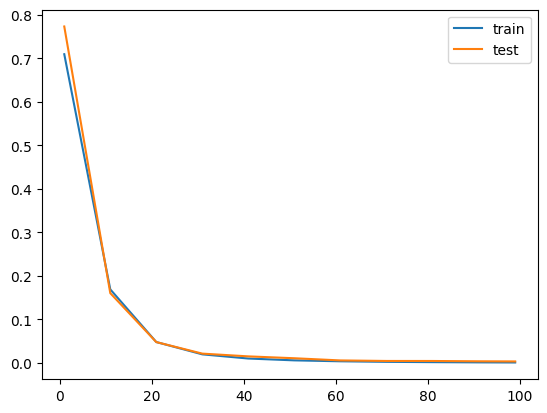

<Figure size 2000x2000 with 0 Axes>

 68%|██████▊   | 678/1000 [00:39<00:31, 10.33it/s]

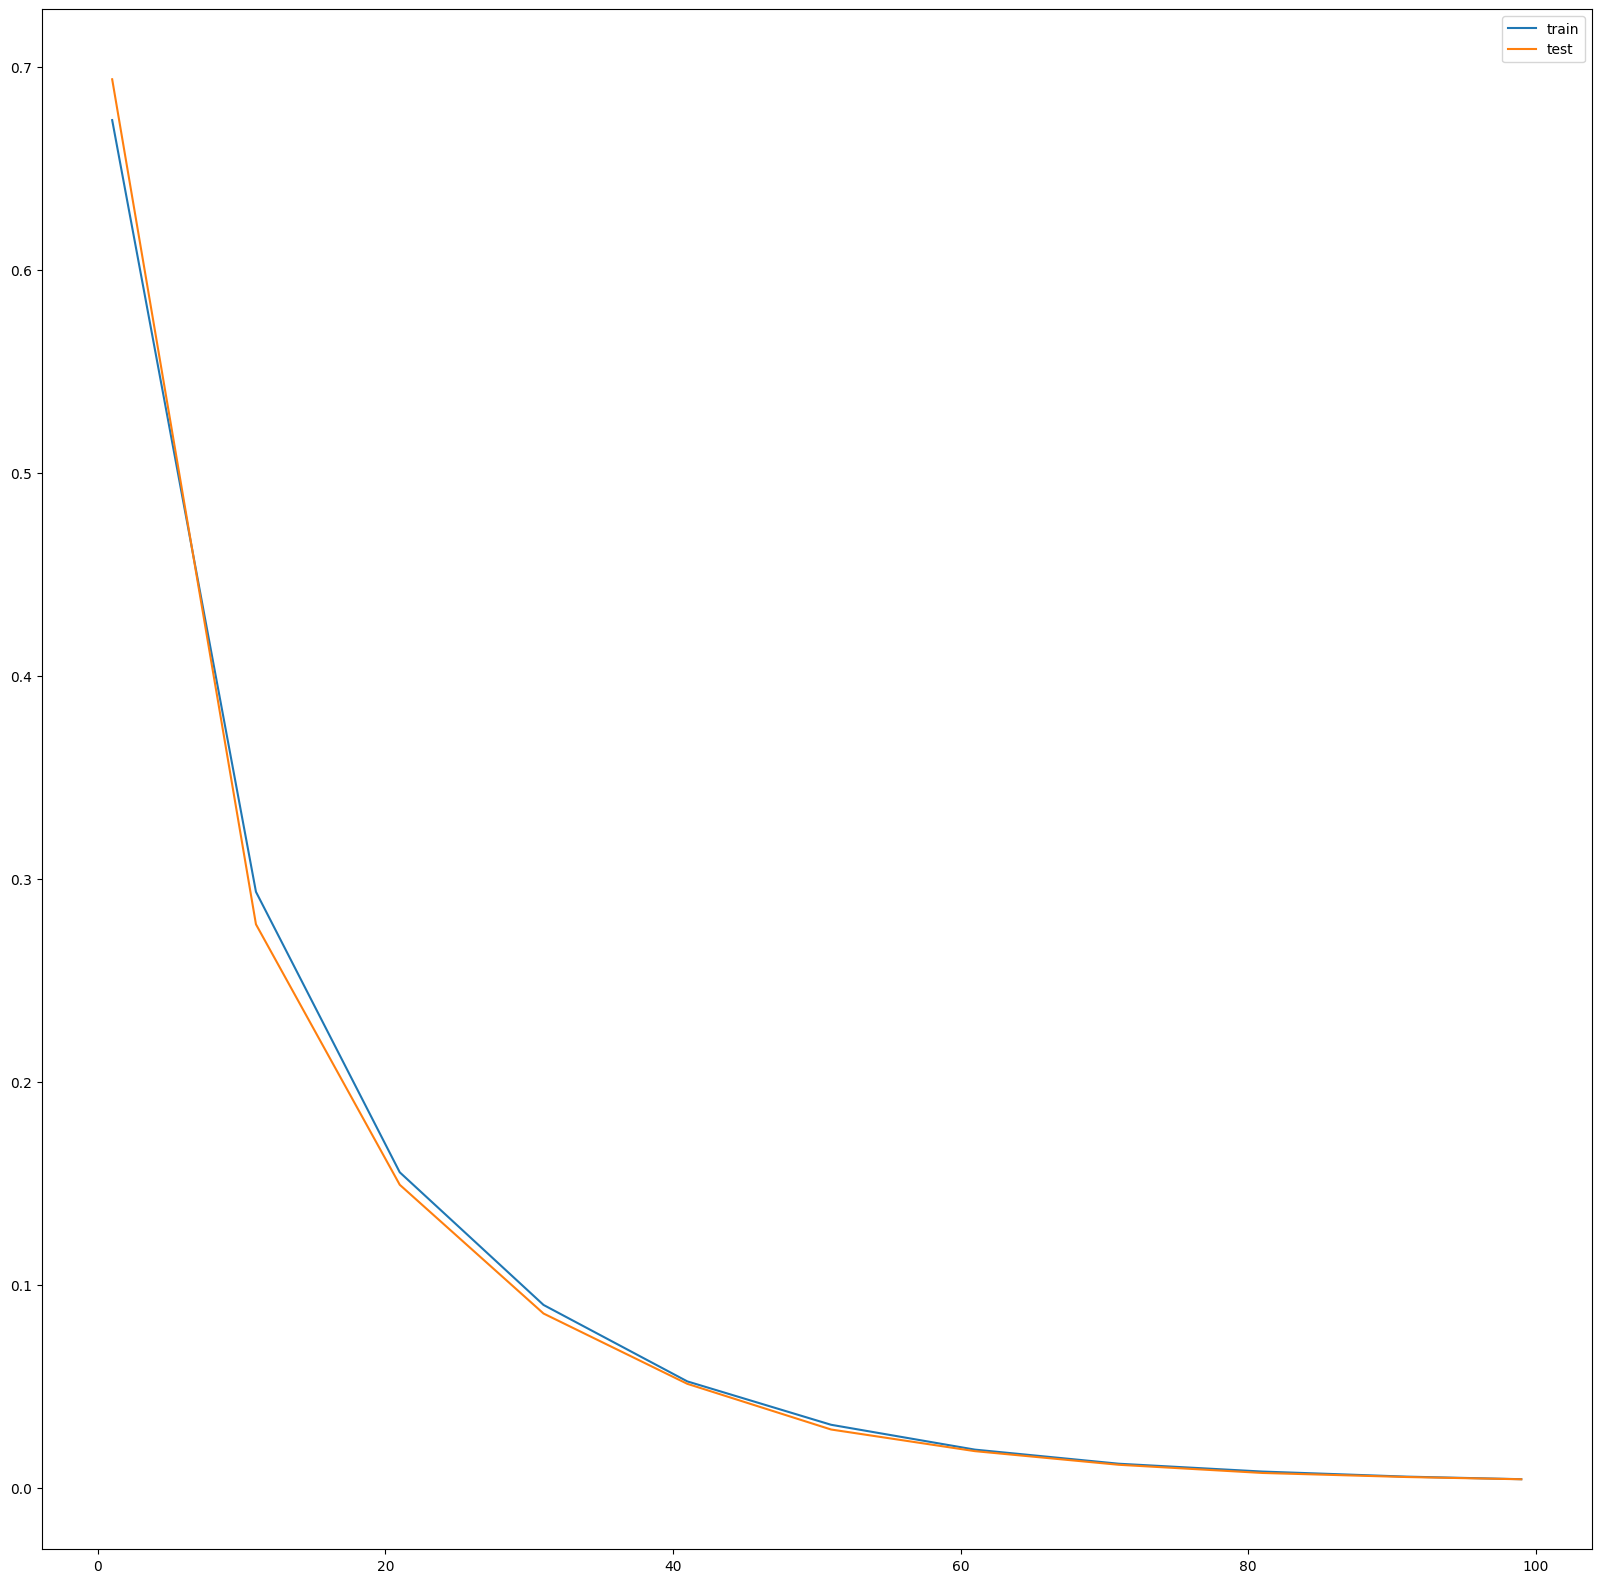

Error in callback <function _WandbInit._pause_backend at 0x7a20fee55510> (for post_run_cell):


BrokenPipeError: ignored

In [44]:
start_with_wandb()
start_with_wandb(set_baseline_true=True)


In [45]:
#!rm *.pth

Error in callback <function _WandbInit._resume_backend at 0x7a20fee57370> (for pre_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7a20fee55510> (for post_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7a20fee55510> (for post_run_cell):


BrokenPipeError: ignored